In [1]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

levels = spark.read.json("../data/magician_levels_20210521.json", multiLine=True).distinct().cache()
ranking = spark.read.json("../data/magician_ranking_20210521.json", multiLine=True).cache()
exptable = spark.read.csv("../data/exptable.csv", header=True, inferSchema=True).cache()
levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")
exptable.createOrReplaceTempView("exptable")
levels.printSchema()
ranking.printSchema()
exptable.printSchema()

root
 |-- level: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- category: string (nullable = true)
 |-- fame: long (nullable = true)
 |-- guild: string (nullable = true)
 |-- job: string (nullable = true)
 |-- level: long (nullable = true)
 |-- mastery: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- specialization: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- level: integer (nullable = true)
 |-- exp: integer (nullable = true)
 |-- cumulative_exp: long (nullable = true)



In [2]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    quantiles as (
        select distinct
            specialization,
            level,
            count(*) over (partition by level, specialization) as n,
            (min(diff) over (partition by level, specialization))/60 as p00,
            (percentile_approx(diff, 0.01) over (partition by level, specialization))/60 as p01,
            (percentile_approx(diff, 0.05) over (partition by level, specialization))/60 as p05,
            (percentile_approx(diff, 0.1) over (partition by level, specialization))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization))/60 as p50
        from ttl
        where diff is not null
        order by 1, 2
    )
    select
        *,
        exp/p00 as epm_p00,
        exp/p01 as epm_p01,
        exp/p05 as epm_p05,
        exp/p10 as epm_p10,
        exp/p50 as epm_p50
    from quantiles
    join exptable
    using (level)
    order by specialization, level
""")
df.show(vertical=True, n=2)

-RECORD 0-----------------------------
 level          | 2                   
 specialization | all                 
 n              | 1                   
 p00            | 0.0                 
 p01            | 0.0                 
 p05            | 0.0                 
 p10            | 0.0                 
 p50            | 0.0                 
 exp            | 34                  
 cumulative_exp | 15                  
 epm_p00        | null                
 epm_p01        | null                
 epm_p05        | null                
 epm_p10        | null                
 epm_p50        | null                
-RECORD 1-----------------------------
 level          | 3                   
 specialization | all                 
 n              | 21118               
 p00            | 0.0                 
 p01            | 0.3333333333333333  
 p05            | 0.48333333333333334 
 p10            | 0.6                 
 p50            | 1.6833333333333333  
 exp            | 57     

In [3]:
pdf = df.toPandas()

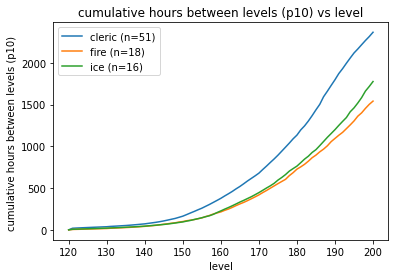

In [18]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level >= 120)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.p10.cumsum()/60, label=f"{name} (n={n})")
plt.title("cumulative hours between levels (p10) vs level")
plt.xlabel("level")
plt.ylabel("cumulative hours between levels (p10) ")
plt.legend()
plt.show()

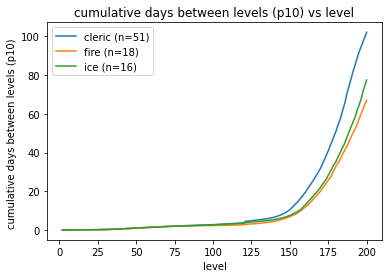

In [20]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.p10.cumsum()/60/24, label=f"{name} (n={n})")
plt.title("cumulative days between levels (p10) vs level")
plt.xlabel("level")
plt.ylabel("cumulative days between levels (p10) ")
plt.legend()
plt.show()

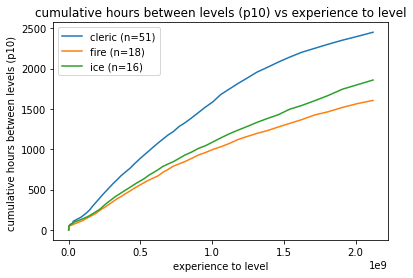

In [31]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.exp, res.p10.cumsum()/60, label=f"{name} (n={n})")
plt.title("cumulative hours between levels (p10) vs experience to level")
plt.xlabel("experience to level")
plt.ylabel("cumulative hours between levels (p10) ")
plt.legend()
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [55]:
df = spark.sql("""
    with counts as (
        select
            date_trunc("month", timestamp) as month,
            case 
                when level < 10 then 0
                when level < 30 then 1
                when level < 70 then 2
                when level < 120 then 3
                else 4
            end as job,
            count(distinct name) as n
        from levels
        group by 1, 2
        order by 1, 2
    )
    select distinct 
        *,
        sum(n) over (partition by month) as total
    from counts
    order by month, job
""")
df.show()

+-------------------+---+---+-----+
|              month|job|  n|total|
+-------------------+---+---+-----+
|2015-10-01 00:00:00|  0|147|  598|
|2015-10-01 00:00:00|  1|177|  598|
|2015-10-01 00:00:00|  2|163|  598|
|2015-10-01 00:00:00|  3| 70|  598|
|2015-10-01 00:00:00|  4| 41|  598|
|2015-11-01 00:00:00|  0|232|  849|
|2015-11-01 00:00:00|  1|264|  849|
|2015-11-01 00:00:00|  2|224|  849|
|2015-11-01 00:00:00|  3| 80|  849|
|2015-11-01 00:00:00|  4| 49|  849|
|2015-12-01 00:00:00|  0|277|  913|
|2015-12-01 00:00:00|  1|295|  913|
|2015-12-01 00:00:00|  2|213|  913|
|2015-12-01 00:00:00|  3| 80|  913|
|2015-12-01 00:00:00|  4| 48|  913|
|2016-01-01 00:00:00|  0|290| 1021|
|2016-01-01 00:00:00|  1|323| 1021|
|2016-01-01 00:00:00|  2|246| 1021|
|2016-01-01 00:00:00|  3| 97| 1021|
|2016-01-01 00:00:00|  4| 65| 1021|
+-------------------+---+---+-----+
only showing top 20 rows



In [56]:
pdf = df.toPandas()

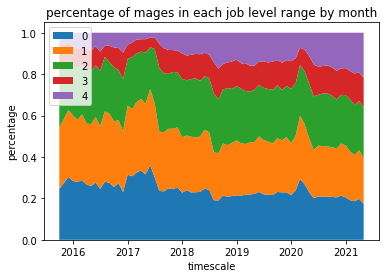

In [76]:
ys = []
for i in range(5):
    res = pdf[pdf.job == i]
    ys.append(res.n/res.total)

plt.stackplot(pdf.month.unique(), *ys, labels=list(range(5)))
plt.title("percentage of mages in each job level range by month")
plt.xlabel("timescale")
plt.ylabel("percentage")
plt.legend(loc="upper left")

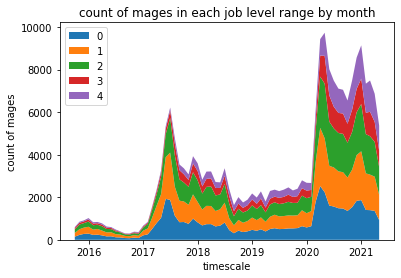

In [74]:
ys = []
for i in range(5):
    res = pdf[pdf.job == i]
    ys.append(res.n)

plt.stackplot(pdf.month.unique(), *ys, labels=list(range(5)))
plt.title("count of mages in each job level range by month")
plt.xlabel("timescale")
plt.ylabel("count of mages")
plt.legend(loc="upper left")

In [84]:
df = spark.sql("""
    with players as (
        select
            date_trunc("month", timestamp) as month,
            lag(timestamp) over (partition by name order by level) as ts,
            name,
            level
        from levels
    ),
    selected as (
        select
            month,
            name,
            max(level) as level,
            max(ts) as ts
        from players
        where ts < month
        group by 1, 2
    ),
    counts as (
        select
            month,
            case 
                when level < 10 then 0
                when level < 30 then 1
                when level < 70 then 2
                when level < 120 then 3
                else 4
            end as job,
            count(distinct name) as n
        from selected
        where
            datediff(month, ts) < 60
        group by 1, 2
        order by 1, 2
    )
    select distinct 
        *,
        sum(n) over (partition by month) as total
    from counts
    order by month, job
""")
pdf = df.toPandas()
pdf

,month,job,n,total
0,2015-11-01,0,5,181
1,2015-11-01,1,34,181
2,2015-11-01,2,74,181
3,2015-11-01,3,35,181
4,2015-11-01,4,33,181
...,...,...,...,...
328,2021-05-01,0,45,2208
329,2021-05-01,1,234,2208
330,2021-05-01,2,625,2208
331,2021-05-01,3,431,2208


In [102]:
res = pdf.groupby("month").count().n
res[res != 5].index

DatetimeIndex(['2016-08-01', '2016-11-01'], dtype='datetime64[ns]', name='month', freq=None)

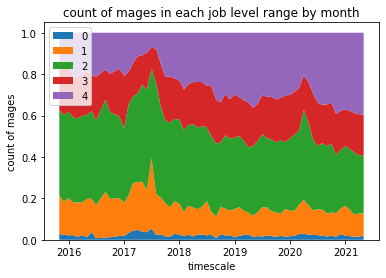

In [105]:
ys = []
for i in range(5):
    res = pdf[(pdf.job == i) & (pdf.month != "2016-08-01") & (pdf.month != "2016-11-01")]
    ys.append(res.n/res.total)

plt.stackplot(pdf[(pdf.month != "2016-08-01") & (pdf.month != "2016-11-01")].month.unique(), *ys, labels=list(range(5)))
plt.title("count of mages in each job level range by month")
plt.xlabel("timescale")
plt.ylabel("count of mages")
plt.legend(loc="upper left")